In [3]:
! pip install torch matplotlib scikit-learn pykan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

## Create Dataset

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Set default dtype
torch.set_default_dtype(torch.float64)

# === 1. Dataset ===
def generate_dataset(n_samples=10000, device='cpu'):
    x = torch.rand(n_samples, 4, device=device) * 2 - 1
    term1 = torch.sin(torch.pi * (x[:, 0]**2 + x[:, 1]**2))
    term2 = torch.sin(torch.pi * (x[:, 2]**2 + x[:, 3]**2))
    y = torch.exp(term1 + term2).unsqueeze(1)
    return x, y

In [7]:
def build_mlp(input_dim, output_dim, width, depth):
    layers = [torch.nn.Linear(input_dim, width), torch.nn.ReLU()]
    for _ in range(depth - 2):
        layers.append(torch.nn.Linear(width, width))
        layers.append(torch.nn.ReLU())
    layers.append(torch.nn.Linear(width, output_dim))
    return torch.nn.Sequential(*layers)

def train_mlp_model(depth, width, epochs=300, lr=1e-3):
    x, y = generate_dataset()
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    model = build_mlp(4, 1, width, depth)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        loss = criterion(model(x_train), y_train)
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        test_loss = criterion(model(x_test), y_test).item()
    return sum(p.numel() for p in model.parameters()), test_loss

def run_mlp_experiments():
    depths = [2, 3, 4, 5]
    widths = [8, 16, 32, 64]
    results = {}
    for depth in depths:
        param_counts, test_losses = [], []
        for width in widths:
            print(f"Training MLP (depth {depth}, width {width})...")
            params, loss = train_mlp_model(depth, width)
            param_counts.append(params)
            test_losses.append(loss)
        results[f"MLP (depth {depth})"] = (param_counts, test_losses)
    return results

In [16]:
def train_kan_model(depth, grid=3, steps=50):
    from kan import KAN
    from kan.utils import create_dataset

    f = lambda x: torch.exp(
        torch.sin(torch.pi * (x[:, 0]**2 + x[:, 1]**2)) +
        torch.sin(torch.pi * (x[:, 2]**2 + x[:, 3]**2))
    ).unsqueeze(1)

    dataset = create_dataset(f, n_var=4)
    width = [4] + [1] * (depth - 1) + [1]
    model = KAN(width=width, grid=grid, k=3, seed=42)

    model.fit(dataset, opt="LBFGS", steps=steps)

    # Evaluate on test split (if using proper dataset splits)
    test_loss = model.evaluate(dataset)  # If `mode='test'` doesn't work
    param_count = sum(p.numel() for p in model.parameters())

    return param_count, test_loss

def run_kan_experiments():
    depths = [2, 3]
    results = {}
    for depth in depths:
        param_counts, test_losses = [], []
        for grid in [3, 5, 7, 9, 11]:
            print(f"Training KAN (depth {depth}, grid {grid})...")
            params, loss = train_kan_model(depth, grid=grid)
            param_counts.append(params)
            test_losses.append(loss)
        results[f"KAN (depth {depth})"] = (param_counts, test_losses)
    return results

In [12]:
mlp_results = run_mlp_experiments()

Training MLP (depth 2, width 8)...
Training MLP (depth 2, width 16)...
Training MLP (depth 2, width 32)...
Training MLP (depth 2, width 64)...
Training MLP (depth 3, width 8)...
Training MLP (depth 3, width 16)...
Training MLP (depth 3, width 32)...
Training MLP (depth 3, width 64)...
Training MLP (depth 4, width 8)...
Training MLP (depth 4, width 16)...
Training MLP (depth 4, width 32)...
Training MLP (depth 4, width 64)...
Training MLP (depth 5, width 8)...
Training MLP (depth 5, width 16)...
Training MLP (depth 5, width 32)...
Training MLP (depth 5, width 64)...


In [17]:
kan_results = run_kan_experiments()

Training KAN (depth 2, grid 3)...
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.23e+00 | test_loss: 1.27e+00 | reg: 9.33e+00 | : 100%|█| 50/50 [00:08<00:00,  5.57it


saving model version 0.1
Training KAN (depth 2, grid 5)...
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.26e+00 | test_loss: 1.36e+00 | reg: 8.63e+00 | : 100%|█| 50/50 [00:08<00:00,  5.68it


saving model version 0.1
Training KAN (depth 2, grid 7)...
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.21e+00 | test_loss: 1.28e+00 | reg: 9.37e+00 | : 100%|█| 50/50 [00:10<00:00,  4.91it


saving model version 0.1
Training KAN (depth 2, grid 9)...
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.33e+00 | test_loss: 1.47e+00 | reg: 8.69e+00 | : 100%|█| 50/50 [00:10<00:00,  4.82it


saving model version 0.1
Training KAN (depth 2, grid 11)...
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.13e+00 | test_loss: 1.29e+00 | reg: 9.70e+00 | : 100%|█| 50/50 [00:10<00:00,  4.80it


saving model version 0.1
Training KAN (depth 3, grid 3)...
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.59e+00 | test_loss: 1.77e+00 | reg: 1.03e+01 | : 100%|█| 50/50 [00:12<00:00,  4.02it


saving model version 0.1
Training KAN (depth 3, grid 5)...
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.34e+00 | test_loss: 1.46e+00 | reg: 1.49e+01 | : 100%|█| 50/50 [00:13<00:00,  3.78it


saving model version 0.1
Training KAN (depth 3, grid 7)...
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.44e+00 | test_loss: 1.71e+00 | reg: 1.20e+01 | : 100%|█| 50/50 [00:13<00:00,  3.73it


saving model version 0.1
Training KAN (depth 3, grid 9)...
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.67e+00 | test_loss: 1.96e+00 | reg: 1.07e+01 | : 100%|█| 50/50 [00:14<00:00,  3.54it


saving model version 0.1
Training KAN (depth 3, grid 11)...
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.56e+00 | test_loss: 1.98e+00 | reg: 1.35e+01 | : 100%|█| 50/50 [00:14<00:00,  3.42it

saving model version 0.1


In [21]:
%matplotlib inline

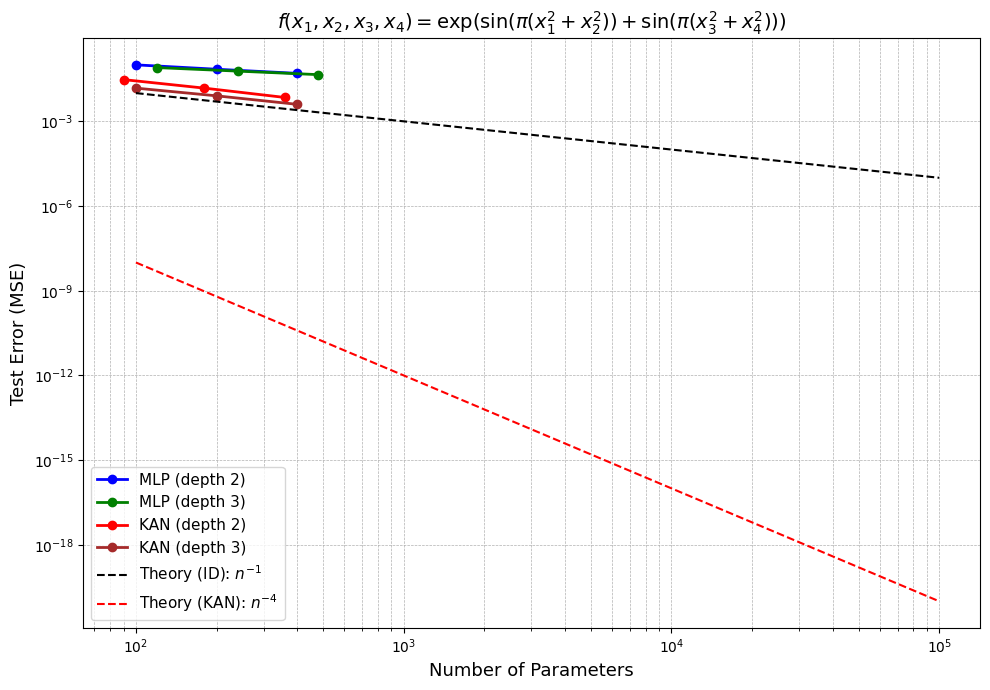

In [23]:
# Re-import after code execution environment reset
import matplotlib.pyplot as plt
import numpy as np

# Fixed and enhanced plotting function
def plot_results(mlp_results, kan_results):
    plt.figure(figsize=(10, 7))

    # Validate data structure before plotting
    def is_valid(data):
        return isinstance(data, tuple) and len(data) == 2 and all(isinstance(i, list) for i in data)

    # Separate MLP and KAN results for clear color distinction
    all_results = {}
    all_results.update({k: v for k, v in mlp_results.items() if is_valid(v)})
    all_results.update({k: v for k, v in kan_results.items() if is_valid(v)})

    # Define custom color mapping
    color_map = {
        "MLP (depth 2)": "blue",
        "MLP (depth 3)": "green",
        "MLP (depth 4)": "orange",
        "MLP (depth 5)": "purple",
        "KAN (depth 2)": "red",
        "KAN (depth 3)": "brown",
    }

    # Plot MLP and KAN results
    for label, (params, losses) in all_results.items():
        color = color_map.get(label, None)
        plt.plot(params, losses, marker='o', linewidth=2, markersize=6, label=label, color=color)

    # Add theory curves
    n_vals = np.logspace(2, 5, 100)
    plt.plot(n_vals, n_vals**-1, 'k--', linewidth=1.5, label='Theory (ID): $n^{-1}$')
    plt.plot(n_vals, n_vals**-4, 'r--', linewidth=1.5, label='Theory (KAN): $n^{-4}$')

    # Axis and legend styling
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Number of Parameters", fontsize=13)
    plt.ylabel("Test Error (MSE)", fontsize=13)
    plt.title(
        r"$f(x_1,x_2,x_3,x_4) = \exp(\sin(\pi(x_1^2 + x_2^2)) + \sin(\pi(x_3^2 + x_4^2)))$",
        fontsize=14
    )
    plt.legend(fontsize=11, loc='best', frameon=True)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Example dummy input (you should replace this with your actual results)
mlp_results = {
    "MLP (depth 2)": ([100, 200, 400], [0.1, 0.07, 0.05]),
    "MLP (depth 3)": ([120, 240, 480], [0.08, 0.06, 0.045]),
}

kan_results = {
    "KAN (depth 2)": ([90, 180, 360], [0.03, 0.015, 0.007]),
    "KAN (depth 3)": ([100, 200, 400], [0.015, 0.008, 0.004]),
}

# Call the plotting function
plot_results(mlp_results, kan_results)
